## 塗りつぶし（その１）

区画を塗りつぶして可視化できないか試みる。

In [1]:
import glob
import functools
import numpy
import pandas as pd
import geopandas as gpd
import sklearn.decomposition
from shapely.geometry import Point
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
import matplotlib
jafont=matplotlib.font_manager.FontProperties(fname="ipaexg.ttf")
ja = dict(fontproperties=jafont)

In [3]:
ages=["%d歳" % i for i in range(100)]+["100歳以上"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

In [4]:
data0 = load_zensi("../data/kobe/zensi2808.xls")

区画データは e-Stat から取得する。

In [5]:
us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib2 = pib[(pib["MOJI"]!="水面") & (pib["MOJI"].isnull()==False)] # 海上を取り除く

神戸市の人口データの `町コード` は e-Stat の `KEYCODE1` と一致する。

In [6]:
pib2_keycodes = set(pib2["KEYCODE1"])
data1 = data0.assign(KEYCODE1=lambda df:df["町コード"][df["町コード"].isin(pib2_keycodes)])

ただし区域が変更されたなどしているので、そのままだと無視できない数の不一致が出る。今のデータだと 500 件近くが未解決。

In [7]:
data1[data1["KEYCODE1"].isnull()].shape

(520, 111)

人口でみると 3% ほど落としてしまう。

In [8]:
data1[data1["KEYCODE1"].isnull()]["合計"].sum()/data1["合計"].sum()

0.03412220468408396

そのため、人口データの地名から推定緯度経度を取り出して、区域データに含まれるかどうかを検査する。

In [9]:
qname = data0.apply(lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]), axis=1)
try:
    cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
except:
    cache = pd.DataFrame([], columns=["lat", "lng"])

qn = pd.DataFrame(qname, columns=["qname"])
qa = qn[data0["町コード"].isin(set(pib2["KEYCODE1"]))==False].join(cache, on="qname", how="inner")
pt = gpd.GeoDataFrame(qa.apply(lambda r:Point(r["lng"], r["lat"]), axis=1), columns=["geometry"], crs="+init=epsg:4326")
pt_mv = gpd.tools.sjoin(pt, pib2.to_crs("+init=epsg:4326"), op="within")

地名から合算対象の区域データを求めたので、先ほどのデータにマージさせる。

In [10]:
data1.loc[pt_mv.index, "KEYCODE1"] = pt_mv["KEYCODE1"]

これで人口の取りこぼしはなくなる。

In [11]:
data1[data1["KEYCODE1"].isnull()]["合計"].sum()

0.0

ひとつの `KEYCODE` は複数の区域に分割されていることがある。具体的には区域データは 2863 行あるが、`KEYCODE` は 2824 行になっている。

In [12]:
pib2.shape, len(set(pib2["KEYCODE1"]))

((2863, 43), 2824)

ここから人口データを面積に応じて区域に再配分する。まず KEYCODE ごとに合算してから、区域に再配分する。

In [13]:
# KEYCODE ごとに合算
pib_ages = data1.groupby("KEYCODE1")[ages].sum()

In [14]:
# 面積に応じて再配分
area=pd.DataFrame(pib2.geometry.area, index=pib2.index, columns=["AREA_SUM"])
area_sum = pd.DataFrame(pd.concat([area, pib2["KEYCODE1"]], axis=1), columns=["AREA_SUM", "KEYCODE1"]).groupby("KEYCODE1").sum()
pib3 = pib2.join(pib_ages, on="KEYCODE1").join(area_sum, on="KEYCODE1")
pib4 = pib3[pib3[ages].isnull().all(axis=1)==False]
pib5 = pib4.loc[:,ages].mul(pib4.geometry.area / pib4["AREA_SUM"], axis=0)

人口の合計は変わらないはずなので、ここで検算しておく。

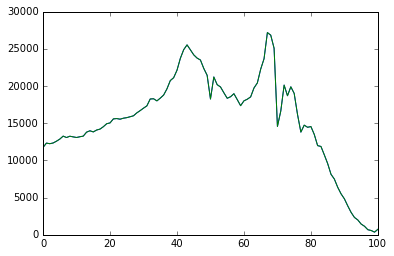

In [15]:
plt.plot(pib5.sum().values)
plt.plot(data0[ages].sum().values)

人口構成比率をそのまま色付けして地図上の区域に表示すると、広い地域が極端に強調されて見えてしまう。そこで面積に応じて透明度をつけて緩和する。特に広い地域と、特に狭い地域の二極端があるので、適宜調整する。

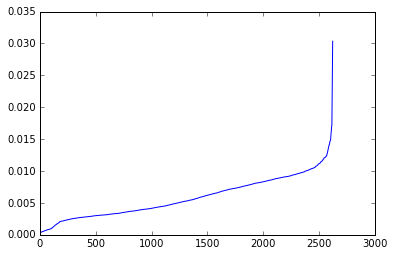

In [16]:
dens = numpy.power(pib4.geometry.area, -1/2)
dens.name="dens"
plt.plot(sorted(dens))

NMF での分解を行う。

In [17]:
m = sklearn.decomposition.NMF(3)
o = m.fit_transform(pib5[ages].values)

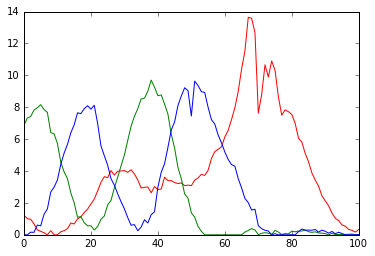

In [18]:
qv = pd.DataFrame(m.components_.dot([i*2 for i in range(101)]), columns=["sort_key"]).sort_values("sort_key", ascending=False)
cc = ["rbg"[list(qv.index).index(i)] for i in range(m.n_components)]
for i,r in enumerate(m.components_):
    plt.plot(r, color=cc[i])

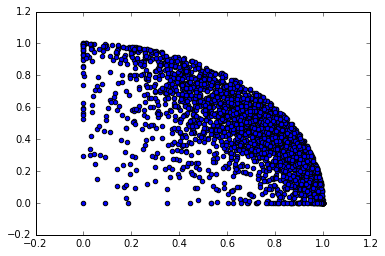

In [19]:
c2 = pd.DataFrame(sklearn.preprocessing.normalize(o), index=pib5.index, columns=cc)
plt.scatter(c2["r"], c2["g"])

透過度も含めた RGBA の色マップを作る。

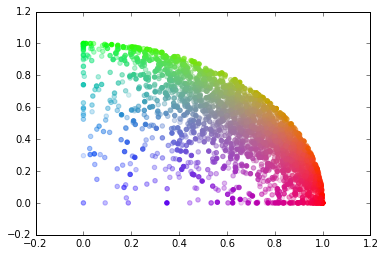

In [20]:
c3 = pd.concat([c2,dens], axis=1).apply(lambda r:tuple([r[i] for i in "rgb"]+[min(r["dens"]/0.01*0.9+0.1, 1.0)]), axis=1)
c3.name="color"
plt.scatter(c2["r"],c2["g"],color=c3)

地図上に描画する。

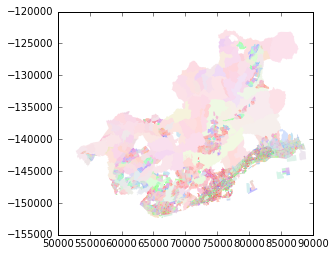

In [21]:
g = gpd.GeoDataFrame(pd.concat([pib4["geometry"], pd.Series(range(len(pib4.index)), index=pib4.index, name="idx")], axis=1))
g.plot(column="idx", cmap=matplotlib.colors.ListedColormap(c3), alpha=None, linewidth=0)

## 塗りつぶし（その２）

人口データはかなり上手？に集められていて、隣接する区画でも大きく異なる様子に表示されやすい。そこで平滑化を試みる。

自分自身を含めた隣接する区画に、人口データを拡散させる。

In [22]:
cpib = gpd.GeoDataFrame(pd.concat([pib2["geometry"],
    pd.Series(pib2.index, index=pib2.index, name="idx"),
    pd.Series([1]*len(pib2.index), index=pib2.index, name="one")], axis=1))
cpib2 = gpd.tools.sjoin(cpib, cpib, how="left", op="intersects")
f = cpib2.groupby("idx_left").sum()["one_right"]
f.name = "count_right"

cpib3 = cpib2.join(pib5, on="idx_left").join(f, on="idx_left")
cpib4 = cpib3.fillna(0)
cpib5 = (cpib4[ages].T/cpib4["count_right"]).T

bpib = pd.concat([cpib4[["idx_left","idx_right"]], cpib5], axis=1).groupby("idx_right").sum()

拡散できたので、検算をしておく。

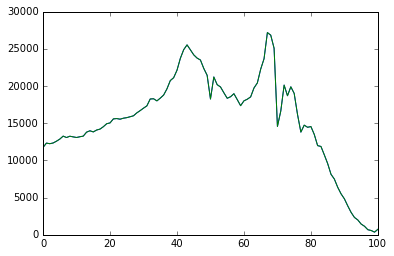

In [23]:
bpib2 = cpib.join(bpib, on="idx")
plt.plot(bpib2[ages].sum().values)
plt.plot(data0[ages].sum().values)

NMF で分解する。

In [24]:
m = sklearn.decomposition.NMF(3)
o = m.fit_transform(bpib2[ages].values)

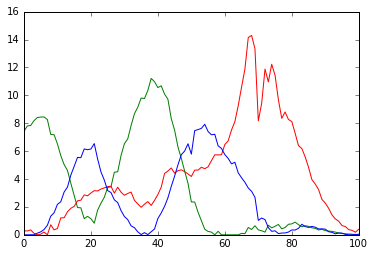

In [25]:
qv = pd.DataFrame(m.components_.dot([i*2 for i in range(101)]), columns=["sort_key"]).sort_values("sort_key", ascending=False)
cc = ["rbg"[list(qv.index).index(i)] for i in range(m.n_components)]
for i,r in enumerate(m.components_):
    plt.plot(r, color=cc[i])

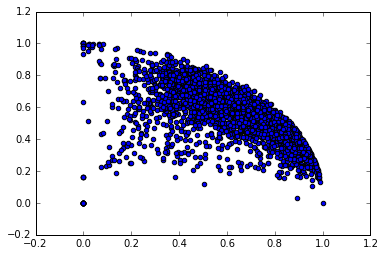

In [26]:
bc2 = pd.DataFrame(sklearn.preprocessing.normalize(o), index=bpib2.index, columns=cc)
plt.scatter(bc2["r"], bc2["g"])

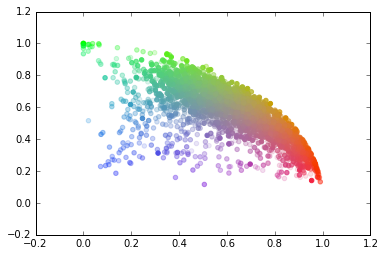

In [27]:
bc3 = pd.concat([bc2,dens], axis=1).apply(lambda r:tuple([r[i] for i in "rgb"]+[min(r["dens"]/0.01*0.9+0.1, 1.0)]), axis=1)
bc3.name="color"
plt.scatter(bc2["r"],bc2["g"],color=bc3)

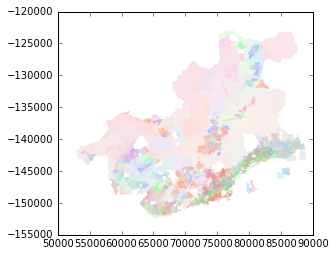

In [28]:
g = gpd.GeoDataFrame(pd.concat([bpib2["geometry"], pd.Series(range(len(bpib2.index)), index=bpib2.index, name="idx")], axis=1))
g.plot(column="idx", cmap=matplotlib.colors.ListedColormap(bc3), alpha=None, linewidth=0)

こちらのほうがわかりやすいですね。